### Sampling symmetric SOEP tensors

We sample $n$ tensors $A \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ for each group $1, \ldots, C$. The size of each dimension of $A$ is $d$, i.e., $I = I_1 = \cdots = I_N = m$. Hereby, each $A$ is a SOEP tensor defined by a set of building vectors $a_1, \ldots, a_r \in \mathbb{R}^m$.

Each input tensor $\mathcal{A}$ is calculated $\mathcal{A} = (A \times_{N} U)^T \times_{0} U$ for orthogonal $m\times m$ matrices $U$.

In [9]:
# Imports
import numpy as np
import pandas as pd
import tensorly as tl

from itertools import product
from scipy.stats import ortho_group
from scipy.linalg import det

import matplotlib.pyplot as plt
import seaborn as sns

# Define seed
seed = 25

In [10]:
def symm_outer_product(x, N):
    
    if N>1:
        return np.multiply.outer(symm_outer_product(x, N-1), x)

    else:
        return x

def create_SOEP_tensor(xs, N):

    # Check if N is even power
    assert N%2 == 0
    
    # Check if list of vectors is not empty
    assert len(xs) != 0

    # Check if all vectors have the same dimension
    assert len(set([x.shape[0] for x in xs])) <= 1

    # Set variables
    r = len(xs)
    m = xs[0].shape[0]

    # Initiate empty tensor A
    A = np.zeros(np.repeat(m,N))

    # Initiate zero nuclear norm nucl_norm
    nucl_norm = 0

    # Sum tensor of even power
    for x in xs:
        A = A + symm_outer_product(x, N)
        nucl_norm = nucl_norm + np.linalg.norm(x)**m

    # Calculate frobenius norm
    frob_norm = np.sqrt(np.sum([a**2 for a in A]))

    # Return tensor A and its nuclear norm and frobenius norm
    return A, nucl_norm, frob_norm

In [11]:
def create_AUTU_tensors_with_A_SOEP(n, C=3, N=3, m=5, diags=np.ones(shape=[3,5]), xs_for_soep=None, target_labels=None):

    # Check inputs
    assert isinstance(n, int) # n should be an integer
    assert isinstance(C, int) # C should be an integer
    assert isinstance(N, int) # N should be an integer
    assert isinstance(m, int) # m should be an integer
    assert len(set(N * [m])) <= 1 # All dimensions should have the same size
    assert len(xs_for_soep) ==  C# There should be C classes
        
    # Set variables
    Is = N * [m]
    
    # Create list of tensors with specified building vectors
    As = []
    # Loop through all classes
    for c in range(C):
        A, _, _ = create_SOEP_tensor(xs_for_soep[c], N)
        A = tl.tensor(A)
        As.append(A)
    
    # Create list of orthogonal matrices
    Us1 = []
    Us2 = []
    Us3 = []
    # Loop through specified number of input tensors per group
    for cnt, nn in enumerate(range(n)):
        
        U1 = ortho_group.rvs(m, random_state=seed*cnt) # Sample orthogonal matrix drawn from the O(N) Haar distribution
        U2 = ortho_group.rvs(m, random_state=seed*cnt) # Sample orthogonal matrix drawn from the O(N) Haar distribution
        U3 = ortho_group.rvs(m, random_state=seed*cnt) # Sample orthogonal matrix drawn from the O(N) Haar distribution
        Us1.append(U1) # Append to list of orthogonal matrices
        Us2.append(U2) # Append to list of orthogonal matrices
        Us3.append(U3) # Append to list of orthogonal matrices
    
    # Create empty data array
    data = np.zeros(shape=[C*n, np.prod(Is)])
    # Loop through combinations of As and Us to calculate (AU)^T U
    #for cnt, (A, U) in enumerate(product(As, Us)):
    for cnt, (A, cntU) in enumerate(product(As, range(n))):
    
        #AUTU = tl.tenalg.mode_dot(tl.transpose(tl.tenalg.mode_dot(A, U, 2), axes=list(range(1,N)) + [0]), U, 0) # Calculate (AU)^T U
        #AUTU = tl.tenalg.mode_dot(tl.tenalg.mode_dot(A, U, N-1), U, 0) # Calculate Ax_3Ux_1U
        AUTU = tl.tenalg.mode_dot(tl.tenalg.mode_dot(tl.tenalg.mode_dot(A, Us1[cntU].T, N-3), Us1[cntU].T, N-2), Us1[cntU].T, N-1) # Calculate A x_1 U^T x_2 U^T x_3 U^T
        #AUTU = tl.tenalg.mode_dot(tl.tenalg.mode_dot(tl.tenalg.mode_dot(A, Us1[cntU], N-3), Us2[cntU], N-2), Us3[cntU], N-1) # Calculate Ax_1Ux_2Ux_3U
        AUTU = AUTU.reshape(-1,) # Reshape tensor to vector
        
        data[cnt,:] = AUTU # Append to data matrix
    
    # Check outputs
    #assert np.sum([(Us[i]==Us[j]).all() for (i,j) in list(product(range(n), range(n)))]) == n # All Us should be different
    assert np.all([abs(1-abs(det(U))) <  np.finfo(np.float32).eps for U in Us1]) # All Us should be orthogonal
    assert data.shape == (C*n, np.prod(Is)) # Dimensions should be number of groups times number of input tensors per group and tensor length

    # Define labels for data
    target = pd.Series(np.repeat(np.array(range(C)), [n]), dtype='category')
    
    # Check if values were provided in function call
    if target_labels is not None:
        # This labels via the input of the function call
        target = target.cat.rename_categories(dict(zip(np.array(range(C)), [target_labels[c] for c in range(C)])))
    else:
        # This labels all singular values of the tensor
        target = target.cat.rename_categories(dict(zip(np.array(range(C)), [('[' + ', '.join(str(round(diags[c,e],2)) for e in range(m)) + ']') for c in range(C)])))  
    
    # Return data matrix
    return As, Us1, data, target

In [12]:
# quadr in 'ne', 'se', 'sw', 'nw'
def sample_spherical(npoints, quadr='ne', ndim=3):

    vec = np.zeros([npoints, ndim])
    
    cnt = 0
    while np.all(vec[npoints-1,:] == np.zeros([1, ndim])):
    
        vec_tmp = np.random.randn(ndim, 1)
        vec_tmp /= np.linalg.norm(vec_tmp, axis=0)

        # north-east
        if np.all(vec_tmp > 0) and quadr=='ne':
            vec[cnt,:] = vec_tmp.ravel()
            cnt = cnt+1 
        # south-west
        elif np.all(vec_tmp < 0) and quadr=='sw':
            vec[cnt,:] = vec_tmp.ravel()
            cnt = cnt+1 
        # any
        elif quadr=='any':
            vec[cnt,:] = vec_tmp.ravel()
            cnt = cnt+1
            
    return vec

In [13]:
def plot_sing_eigen_values(evals, a=0, b=25, m=None, typ='Eigenvalues'):

    # Visualize the eigenvalues
    fig=plt.figure(figsize=(10, 6))
    plt.plot(range(b), evals[1:][range(a,b)], marker='o', linestyle='-', color='b')

    # Plot vertical line if m is provided
    if m is not None:
        plt.axvline(x=m, color='orange', linestyle='--')
        
    plt.title(f'Decay of {typ}')
    plt.xlabel(f'{typ} Index')
    plt.ylabel(f'{typ}')
    plt.grid(True)
    plt.show()

    return fig

In [14]:
def plot_dim_red_in_2_dims(Y, target, title, legend_title, show_legend=True, xlim=None, ylim=None):    
                   
    # Create dataframe 
    df_dim_red = pd.DataFrame({
        '1st reduced dimension': Y[0,:],
        '2nd reduced dimension': Y[1,:],
        'cat': target
    })

    # Define markers for visualization depending on number of target categories (classes)
    if len(target.cat.categories)==2:
        markers = {target.cat.categories[0]: 's',
                   target.cat.categories[1]: '.'}

    elif len(target.cat.categories)==3:
         markers = {target.cat.categories[0]: 's',
                    target.cat.categories[1]: '.',
                    target.cat.categories[2]: 'v'}

    elif len(target.cat.categories)==4:
         markers = {target.cat.categories[0]: 's',
                    target.cat.categories[1]: '.',
                    target.cat.categories[2]: 'v',
                    target.cat.categories[3]: '*',}

    elif len(target.cat.categories)==6:
        markers = {target.cat.categories[0]: 's',
                   target.cat.categories[1]: '.',
                   target.cat.categories[2]: 'v',
                   target.cat.categories[3]: '*',
                   target.cat.categories[4]: 'o',
                   target.cat.categories[5]: 'D'}

    elif len(target.cat.categories)==8:
        markers = {target.cat.categories[0]: 's',
                   target.cat.categories[1]: '.',
                   target.cat.categories[2]: 'v',
                   target.cat.categories[3]: '*',
                   target.cat.categories[4]: 'o',
                   target.cat.categories[5]: 'D',
                   target.cat.categories[6]: '^',
                   target.cat.categories[7]: 'H'}
        
    # Visualize the dimensionality reduction
    if show_legend:
        ax = sns.scatterplot(data=df_dim_red, x='1st reduced dimension', y='2nd reduced dimension', hue='cat', style='cat', markers=markers, legend='auto')     
        ax.set_title(title)
        ax.get_legend().set_title(legend_title)
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        sns.move_legend(ax, "lower right")
    else:
        ax = sns.scatterplot(data=df_dim_red, x='1st reduced dimension', y='2nd reduced dimension', hue='cat', style='cat', markers=markers, legend=None)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    fig = ax.get_figure()
    plt.show()

    return fig

#### Define inputs

We sample $n$ tensors $A \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ for each group $1, \ldots, C$. The size of each dimension of $A$ is $d$, i.e., $I = I_1 = \cdots = I_N = m$. Hereby, each $A$ is a SOEP tensor defined by a set of building vectors $a_1, \ldots, a_r \in \mathbb{R}^m$.

Each input tensor $\mathcal{A}$ is calculated $\mathcal{A} = (A \times_{N} U)^T \times_{0} U$ for orthogonal $m\times m$ matrices $U$.

In [15]:
# Number of input tensors per group
n = 500

# Number of groups
C = 4

# Order of tensors
N = 4

# Size of dimensions of tensor (set all dimensions equal)
m = 3

# Definition of building vectors
xs_for_soep = []
#xs_for_soep.append(sample_spherical(npoints=5, ndim=m, quadr='ne')) # this works!
#xs_for_soep.append(sample_spherical(npoints=5, ndim=m, quadr='sw')) # this works!
xs_for_soep.append(np.repeat(1,m) * sample_spherical(npoints=5, ndim=m, quadr='ne'))
xs_for_soep.append([1, 1, -1] * sample_spherical(npoints=5, ndim=m, quadr='ne'))
xs_for_soep.append([-1, -1, 1] * sample_spherical(npoints=5, ndim=m, quadr='ne'))
xs_for_soep.append(np.repeat(-1,m) * sample_spherical(npoints=5, ndim=m, quadr='ne'))

# Definition of legend title
legend_title = "Signs of $a_i$"
# Definition of target labels
signs = []
signs.append('+++')
signs.append('++-')
signs.append('--+')
signs.append('---')
target_labels = [f'$S_{{\\mathcal{{A}}_{i+1}}}$ : ${signs[i]}$' for i in range(C)]

# Create data 
As, Us, data, target = create_AUTU_tensors_with_A_SOEP(n=n, C=C, N=N, m=m, xs_for_soep=xs_for_soep, target_labels=target_labels)

### Apply manifold learning

#### Principal component analysis (PCA)

In [17]:
# Imports
%run linear/pca/pca.ipynb

SVD is used as n_observations (2000) > n_features (81)


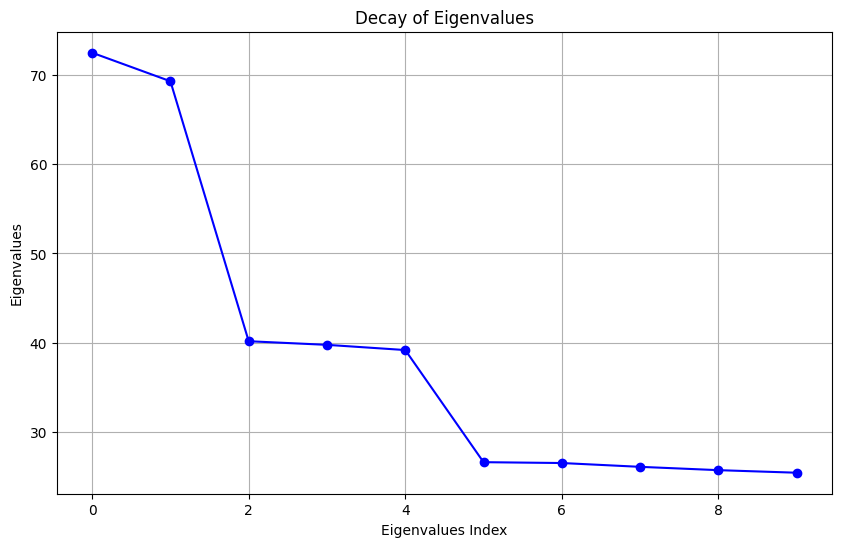

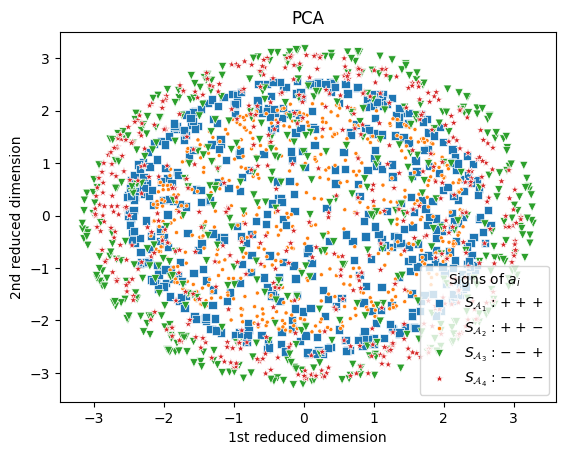

In [18]:
# Get PCA
pca_eigenvalues, pca_eigenvectors, pca_Y = get_pca(data, dim=2)

# Plot eigenvalues with index in [a,b]
fig1 = plot_sing_eigen_values(pca_eigenvalues, a=0, b=10, m=None, typ='Eigenvalues')

# Plot dimensionality reduction in two dimensions
title = "PCA"
fig2 = plot_dim_red_in_2_dims(np.real(pca_Y.T), target, title=title, legend_title=legend_title, xlim=None, ylim=None)

#### Multidimensional Scaling (MDS)

In [19]:
# Imports
%run linear/mds/mds.ipynb

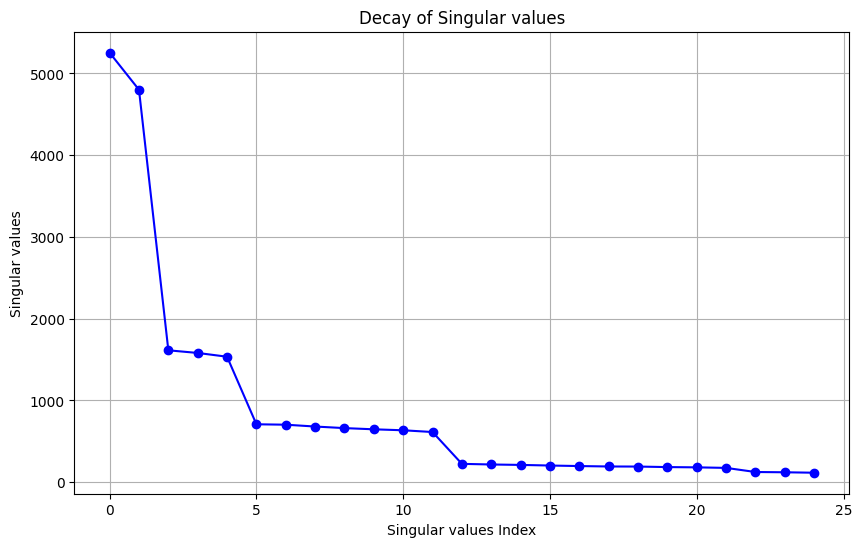

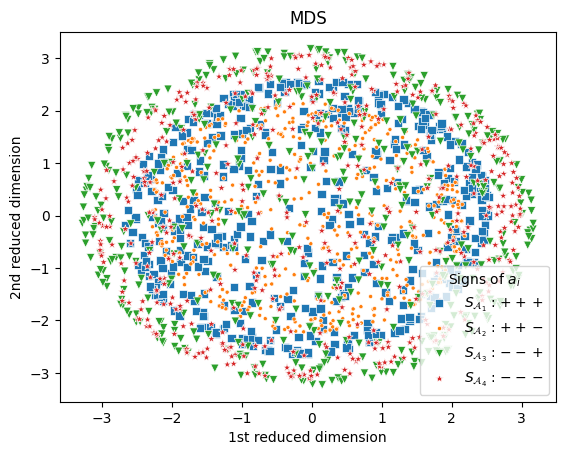

In [20]:
# Get MDS
mds_singvalues, mds_Y = get_mds(data, dim=2)

# Plot singular values with index in [a,b]
fig1 = plot_sing_eigen_values(mds_singvalues, a=0, b=25, m=None, typ='Singular values')

# Plot dimensionality reduction in two dimensions
title = "MDS"
fig2 = plot_dim_red_in_2_dims(np.real(mds_Y), target, title=title, legend_title=legend_title, xlim=None, ylim=None)

#### Isometric feature mapping (ISOMAP)

In [21]:
# Imports
%run non_linear/isomap/isomap.ipynb

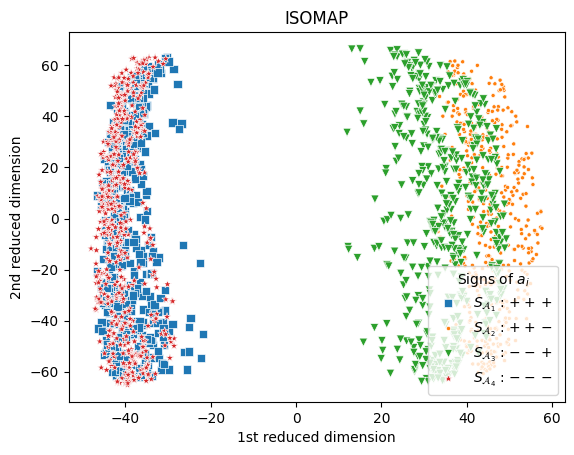

In [22]:
# Get ISOMAP
isomap_Y = get_isomap(X=data, d=2, nghbd_def='k', n_neighbors=30)

# Plot dimensionality reduction in two dimensions
title = "ISOMAP"
fig2 = plot_dim_red_in_2_dims(np.real(isomap_Y), target, title=title, legend_title=legend_title, xlim=None, ylim=None)

#### Diffusion maps (DMs)

In [23]:
# Imports
%run non_linear/dm/dm.ipynb

0.0%
6.25%
12.5%
18.75%
25.0%
31.25%
37.5%
43.75%
50.0%
56.25%
62.5%
68.75%
75.0%
81.25%
87.5%
93.75%


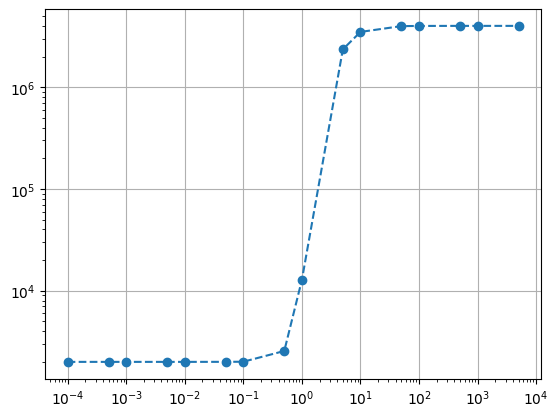

In [24]:
# Find optimal eps for a Gaussian kernel
find_opt_eps_for_dm(data, n_eps=4)

Run diffusion maps algorithm with an exponential kernel (eps=0.7) and t=1


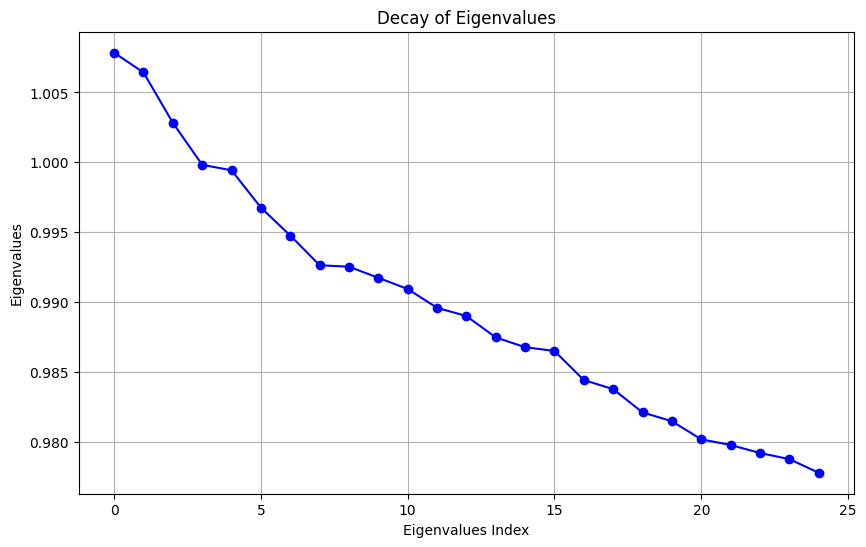

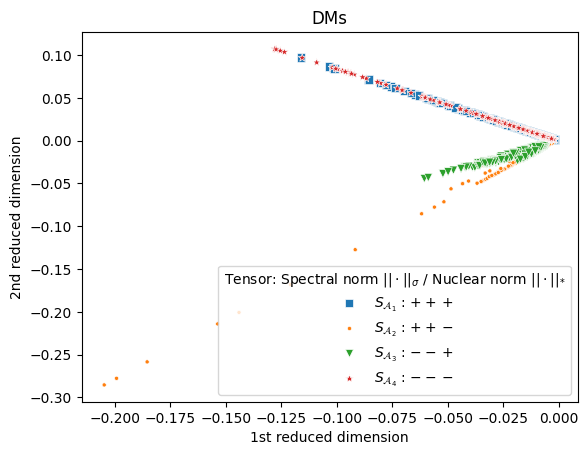

In [25]:
# Get DMs
dm_evals, dm_evecs, dm_Y = get_diffusion_map(X=data, dim=2,
                                             kernel='exp', epsilon=.7,
                                             #kernel='polynom', d=20,
                                             #kernel='sigmoid', g=1, c0=1,
                                             plot_eigenvalues=False, t=1)

# Plot eigenvalues with index in [a,b]
fig1 = plot_sing_eigen_values(dm_evals, a=0, b=25, m=None, typ='Eigenvalues')

# Plot dimensionality reduction in two dimensions
title = "DMs"
legend_title = "Tensor: Spectral norm $||\cdot||_{\sigma}$ / Nuclear norm $||\cdot||_{*}$"
fig2 = plot_dim_red_in_2_dims(np.real(dm_Y[:2,:]), target, title=title, legend_title=legend_title, xlim=None, ylim=None)